#### EDA и предобработка данных

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install datasets transformers scikit-learn nltk imbalanced-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda

In [2]:
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from datasets import load_dataset

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    pipeline,
)

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
dataset = load_dataset('ucirvine/sms_spam') # загружаем датасет с HuggingFace
df = pd.DataFrame(dataset['train'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [4]:
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [5]:
df.shape

(5574, 2)

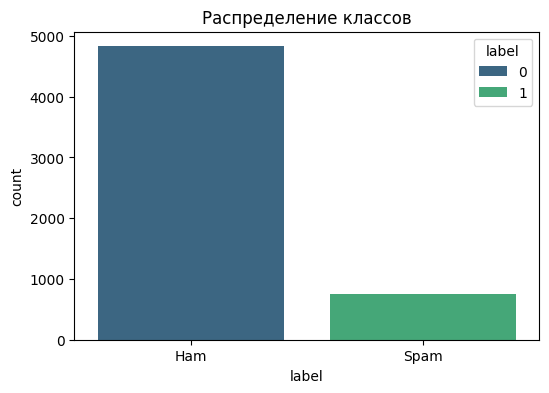

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='viridis', hue='label')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.title('Распределение классов');

In [7]:
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

In [8]:
def preprocess(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()  # удаление спецсимволов + lowercase
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]  # лемматизация
    return ' '.join(words)

In [9]:
df['text_clean'] = df['sms'].apply(preprocess)

In [10]:
df.head()

,sms,label,text_clean
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...\n,0,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think go usf life around though


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'],
    df['label'],
    test_size=0.2,
    stratify=df['label'], # сохраняем распределение классов в выборках
    random_state=42
)

In [12]:
vectorizer = TfidfVectorizer(max_features=5000) # векторизуем с помощью TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#### Baseline: Naive Bayes

In [13]:
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)

In [14]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.98      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [50]:
y_probs_nb = model_nb.predict_proba(X_test_tfidf)[:, 1]

In [51]:
precision_nb, recall_nb, _ = precision_recall_curve(y_test, y_probs_nb)

In [52]:
pr_auc_nb = auc(recall_nb, precision_nb)
print(f"PR-AUC для Naive Bayes: {pr_auc_nb:.3f}")

PR-AUC для Naive Bayes: 0.959


#### DistilBERT

In [16]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
def tokenize_function(examples):
    return tokenizer(
        examples['sms'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

In [21]:
tokenized_datasets = dataset.map(tokenize_function, batched=True) # Применяем токенизацию

Map:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [22]:
split_datasets = tokenized_datasets['train'].train_test_split(
    test_size=0.25,
    stratify_by_column='label',
    seed=42
)

In [23]:
test_valid = split_datasets['test'].train_test_split(test_size=0.5, seed=42) # дополнительно делим тестовую выборку на validation/test

In [24]:
# Итоговые наборы данных
train_dataset = split_datasets['train']
val_dataset = test_valid['train']
test_dataset = test_valid['test']

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label={0: 'ham', 1: 'spam'},
    label2id={'ham': 0, 'spam': 1}
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01, # регуляризация
    save_strategy='no',
    logging_steps=50,
    report_to='none',
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
# функция для вычисления основных метрик
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'f1': f1_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro')
    }

In [28]:
# Взвешивание классов (для дисбаланса)
n_class_0 = sum(df['label'] == 0)
n_class_1 = sum(df['label'] == 1)
total_samples = len(df)

class_weights = torch.tensor(
    [
        total_samples / (2 * n_class_0),
        total_samples / (2 * n_class_1)
    ],
    dtype=torch.float
)

In [29]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # функция потерь
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [30]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.134900,0.069620,0.981216,0.981216,0.981216
2,0.078100,0.046250,0.984419,0.982215,0.986651
3,0.004800,0.045580,0.984560,0.978117,0.991259
4,0.031100,0.052107,0.987478,0.987478,0.987478
5,0.002800,0.070333,0.984274,0.986536,0.982043


TrainOutput(global_step=1310, training_loss=0.052827007978095294, metrics={'train_runtime': 250.3643, 'train_samples_per_second': 83.478, 'train_steps_per_second': 5.232, 'total_flos': 692142157977600.0, 'train_loss': 0.052827007978095294, 'epoch': 5.0})

In [36]:
# сохраняем модель
model.save_pretrained('/drive/MyDrive/Colab Notebooks/spam_classifier_distilbert')
tokenizer.save_pretrained('/drive/MyDrive/Colab Notebooks/spam_classifier_distilbert')

('/drive/MyDrive/Colab Notebooks/spam_classifier_distilbert/tokenizer_config.json',
 '/drive/MyDrive/Colab Notebooks/spam_classifier_distilbert/special_tokens_map.json',
 '/drive/MyDrive/Colab Notebooks/spam_classifier_distilbert/vocab.txt',
 '/drive/MyDrive/Colab Notebooks/spam_classifier_distilbert/added_tokens.json',
 '/drive/MyDrive/Colab Notebooks/spam_classifier_distilbert/tokenizer.json')

In [32]:
# делае прогноз на тестовом наборе данных
test_results = trainer.predict(test_dataset)
test_results.metrics

{'test_loss': 0.15254728496074677,
 'test_f1': 0.9783836710100173,
 'test_precision': 0.9849982033776501,
 'test_recall': 0.9720230809582094,
 'test_runtime': 2.6352,
 'test_samples_per_second': 264.5,
 'test_steps_per_second': 16.697}

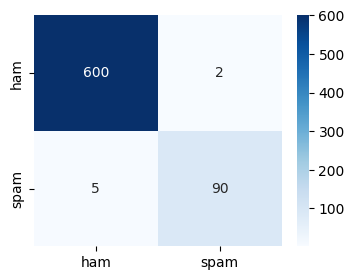

In [33]:
# матрица ошибок
y_true = test_dataset['label']
y_pred = np.argmax(test_results.predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam']);

##### Инференс на новых данных

In [37]:
# Загрузка сохраненной модели
classifier = pipeline(
    'text-classification',
    model='/drive/MyDrive/Colab Notebooks/spam_classifier_distilbert',
    tokenizer=tokenizer
)

# Пример предсказания
sample_text = 'URGENT! You have won a $1000 prize. Click here to claim.'
result = classifier(sample_text)
result

Device set to use cuda:0


[{'label': 'spam', 'score': 0.9996076226234436}]

##### PR-AUC

In [38]:
# Извлечение вероятностей для класса 'spam' (метка 1)
probs = torch.nn.functional.softmax(torch.tensor(test_results.predictions), dim=1)
y_probs = probs[:, 1].numpy()  # Вероятности класса 1 (spam)
y_true = test_dataset['label']  # Истинные метки

In [45]:
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

In [46]:
pr_auc = auc(recall, precision)
print(f'PR-AUC: {pr_auc:.3f}')

PR-AUC: 0.994


1. **Ожидаемо, DistilBERT превосходит Naive Bayes по ключевым метрикам**:

  * Улучшение F1 на 4% (0.93 → 0.97) — более сбалансированная производительность с точки зрения Precision и Recall.
  * PR-AUC близок к максимальному (0.959 → 0.994).

2. **Критические улучшения**:

  * Recall для спама: +7% (0.90 → 0.97) — модель пропускает значительно меньше спама.
  * Ложные срабатывания: -1% (precision 0.98 → 0.990) — меньше легитимных сообщений помечаются как спам.